# 2-colour imaging: RecB-Halo + Nucleoid (Sytox)

In [1]:
from pyberries.data import DatasetPool, get_histogram
import seaborn.objects as so
import pandas as pd

data = (DatasetPool(path='/media/daniel/HDD Daniel/DanielThedie/BACMMAN/Timelapse',
                    dsList=['240424_1', '240612_1', '240620_1',
                            '240717_3',
                            '240620_3', '240717_1', '240717_2',
                            '240717_4',
                            '240424_2', '240612_2', '240620_2'
                            ],
                    groups=['0', '0', '0',
                            '3 ng/mL',
                            '10 ng/mL', '10 ng/mL', '10 ng/mL',
                            '20 ng/mL',
                            '30 ng/mL', '30 ng/mL', '30 ng/mL'
                            ],
                    metadata='DateTime'
                    )
        .heatmap_metrics(object_name=['Nucleoid', 'RecB_spots'])
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .bin_column(col='Time_min', binsize=15, binlabels='left')
        )

Dataset 240424_1 (group 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_1 (group 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240620_1 (group 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240717_3 (group 3 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240620_3 (group 10 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240717_1 (group 10 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240717_2 (group 10 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240717_4 (group 20 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_2 (group 30 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_2 (group 30 ng/mL): loaded objects ['Bacteri

In [ ]:
data.describe()

## Nucleoid compaction

c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
 

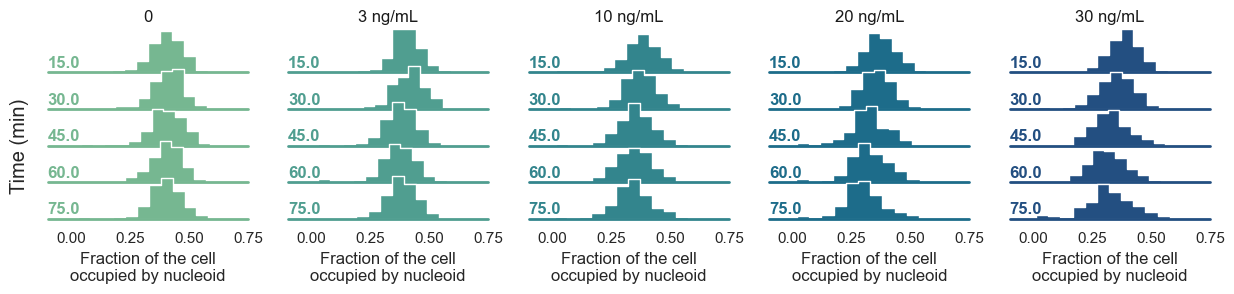

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = (data
      .add_from_child(object_name='Bacteria_large', child='Nucleoid', col='Nucleoid_size', agg='sum')
      .Bacteria_large
      .assign(frac_nucleoid=lambda df: df.Nucleoid_size / df.Area)
      )

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="Time_min_bin", col='Group', hue="Group", aspect=6, height=.5, palette='crest')
g.map(sns.histplot, 'frac_nucleoid', binwidth=0.05, common_norm=False, stat='probability', alpha=1, element='step', edgecolor='w')

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(row, color, label):
      ax = plt.gca()
      ax.text(0, .2, row.iloc[0], fontweight="bold", color=color,
              ha="left", va="center", transform=ax.transAxes)
      if row.iloc[0] == 15.0:
            ax.text(.5, 1.2, label, color='k',
                  ha="center", va="center", transform=ax.transAxes)

g.map(label, 'Time_min_bin')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.2)
g.figure.supylabel('Time (min)', x=.1, y=.4)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel='Fraction of the cell\noccupied by nucleoid', xlim=(-0.1,0.75))
g.despine(bottom=True, left=True)
plt.show()

## Nucleoid position

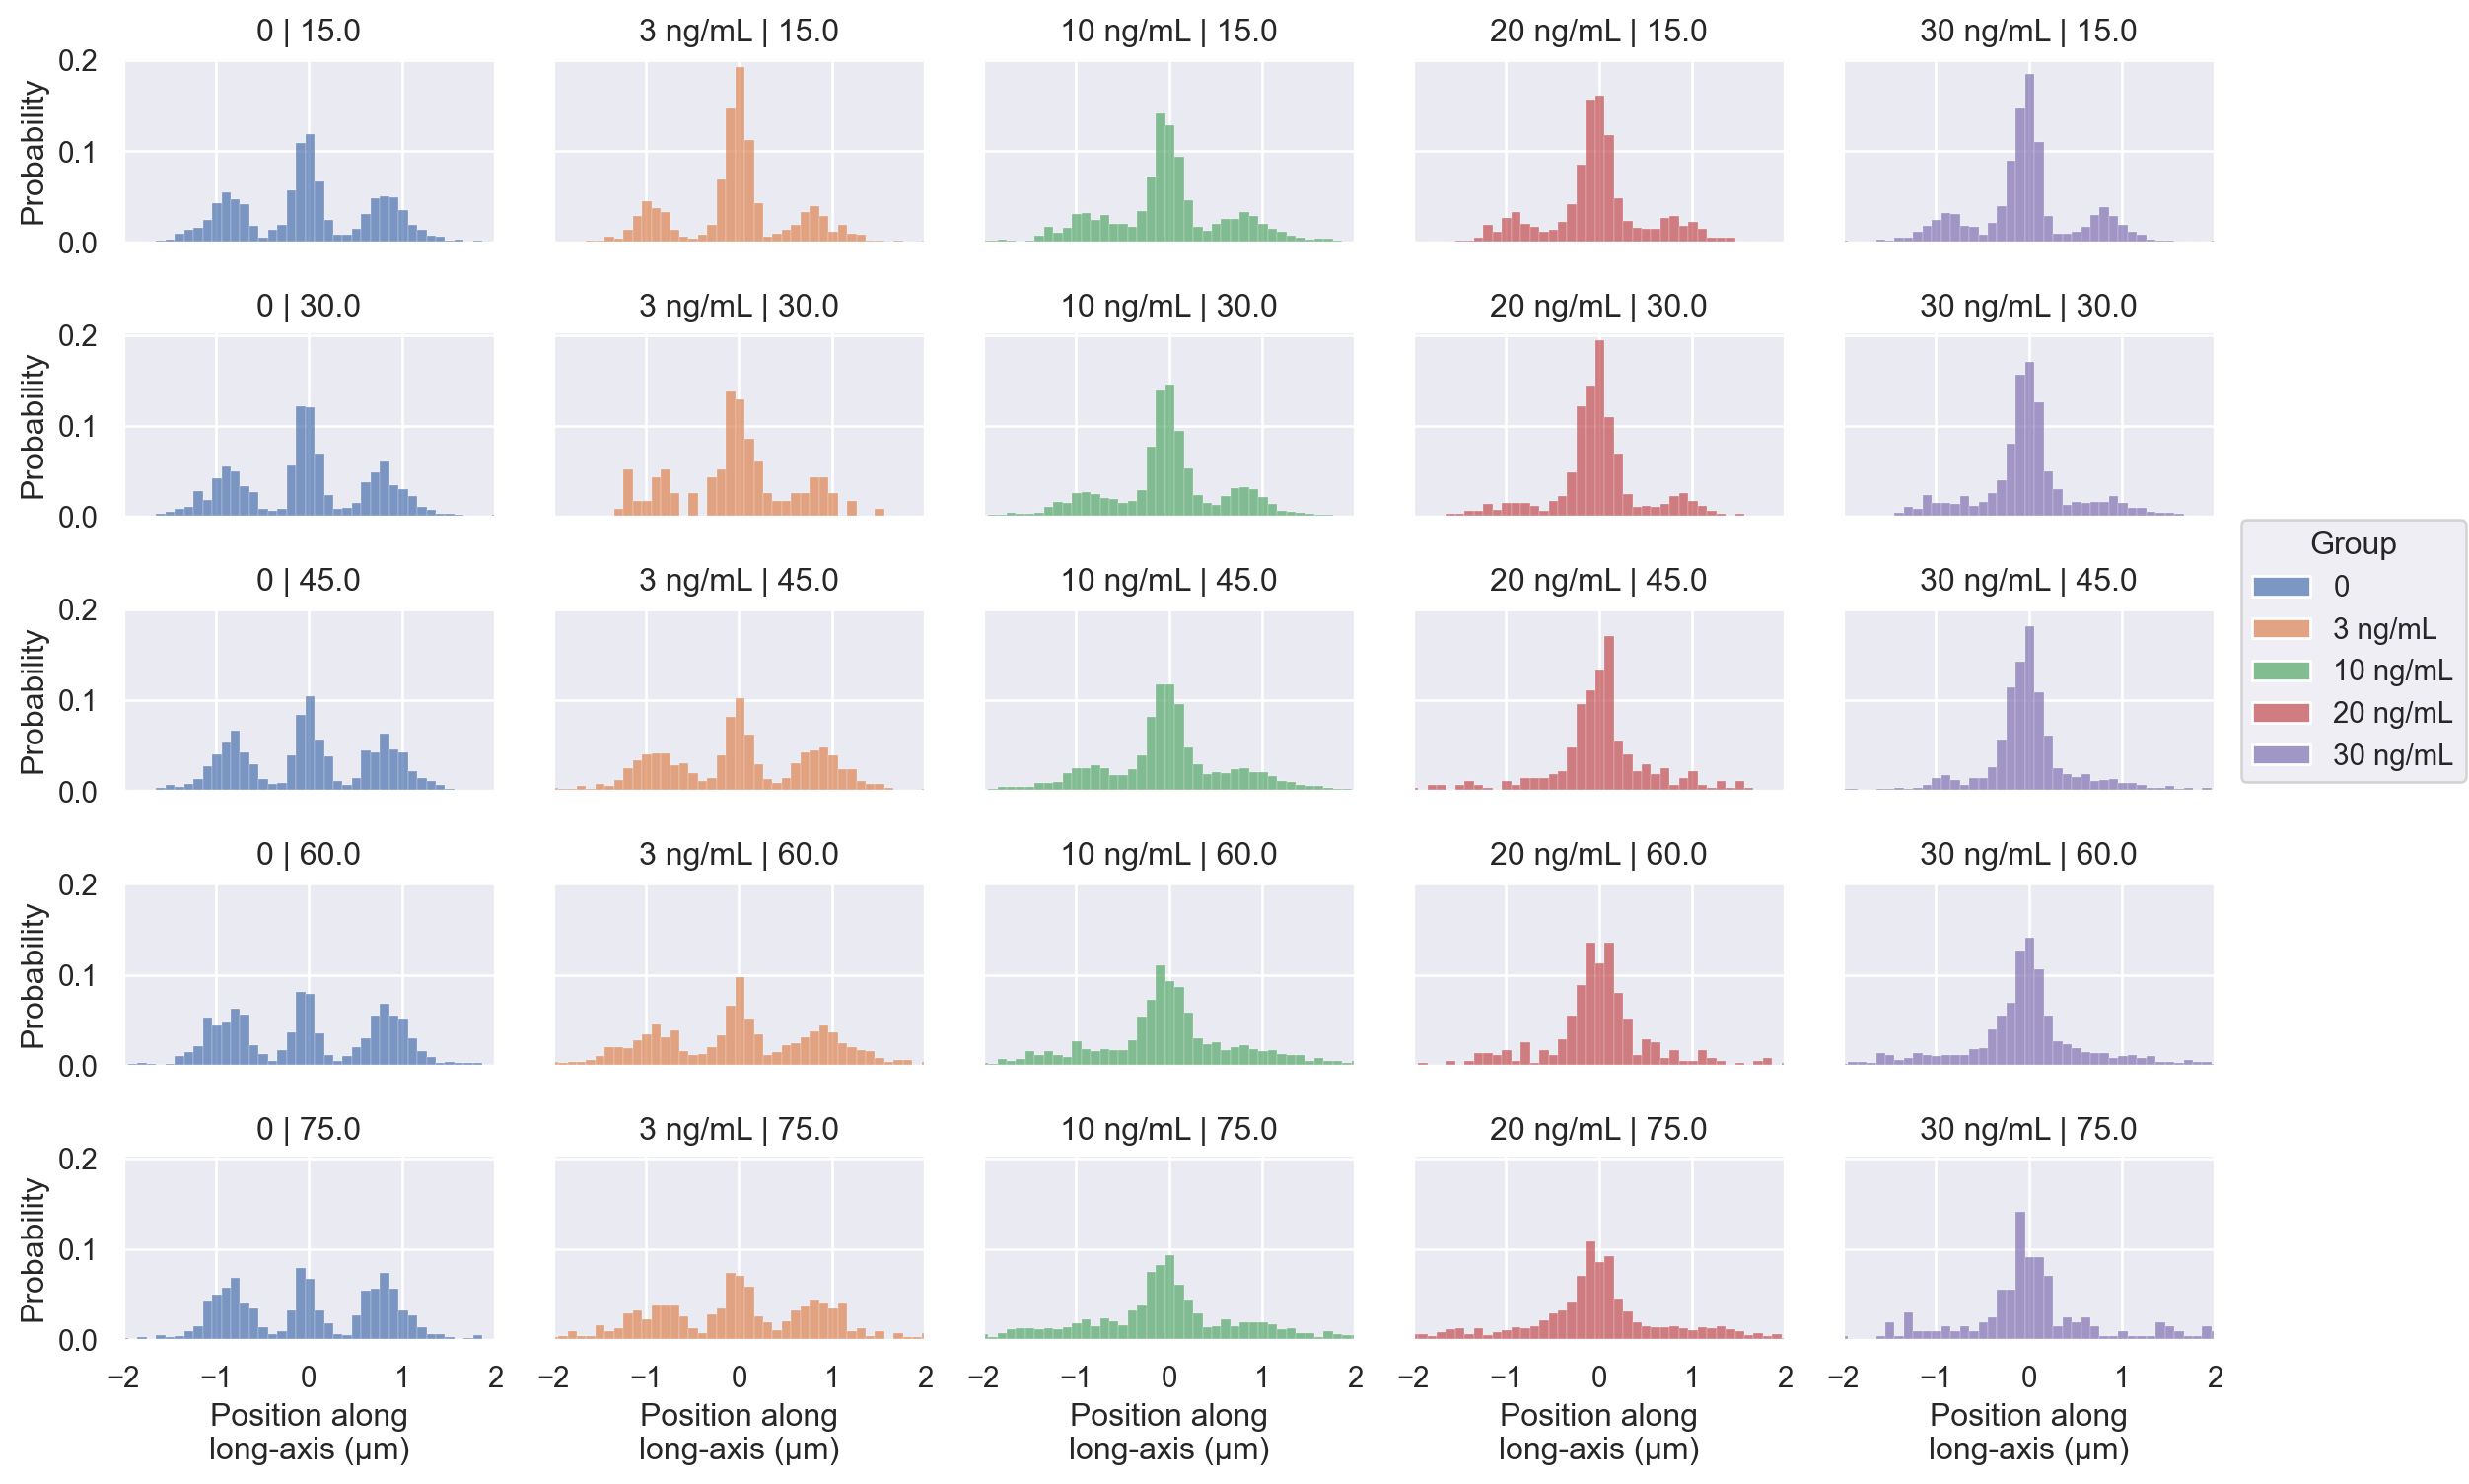

In [5]:
df = data.Nucleoid

(
    so.Plot(df, x='centerLongCoord', color='Group')
    .layout(size=(12, 8))
    .facet(row='Time_min_bin', col='Group')
    .add(so.Bars(), so.Hist(stat='probability', binwidth=0.1, common_norm=False))
    .limit(x=(-2, 2))
    .label(x='Position along\nlong-axis (µm)', y='Probability')
)

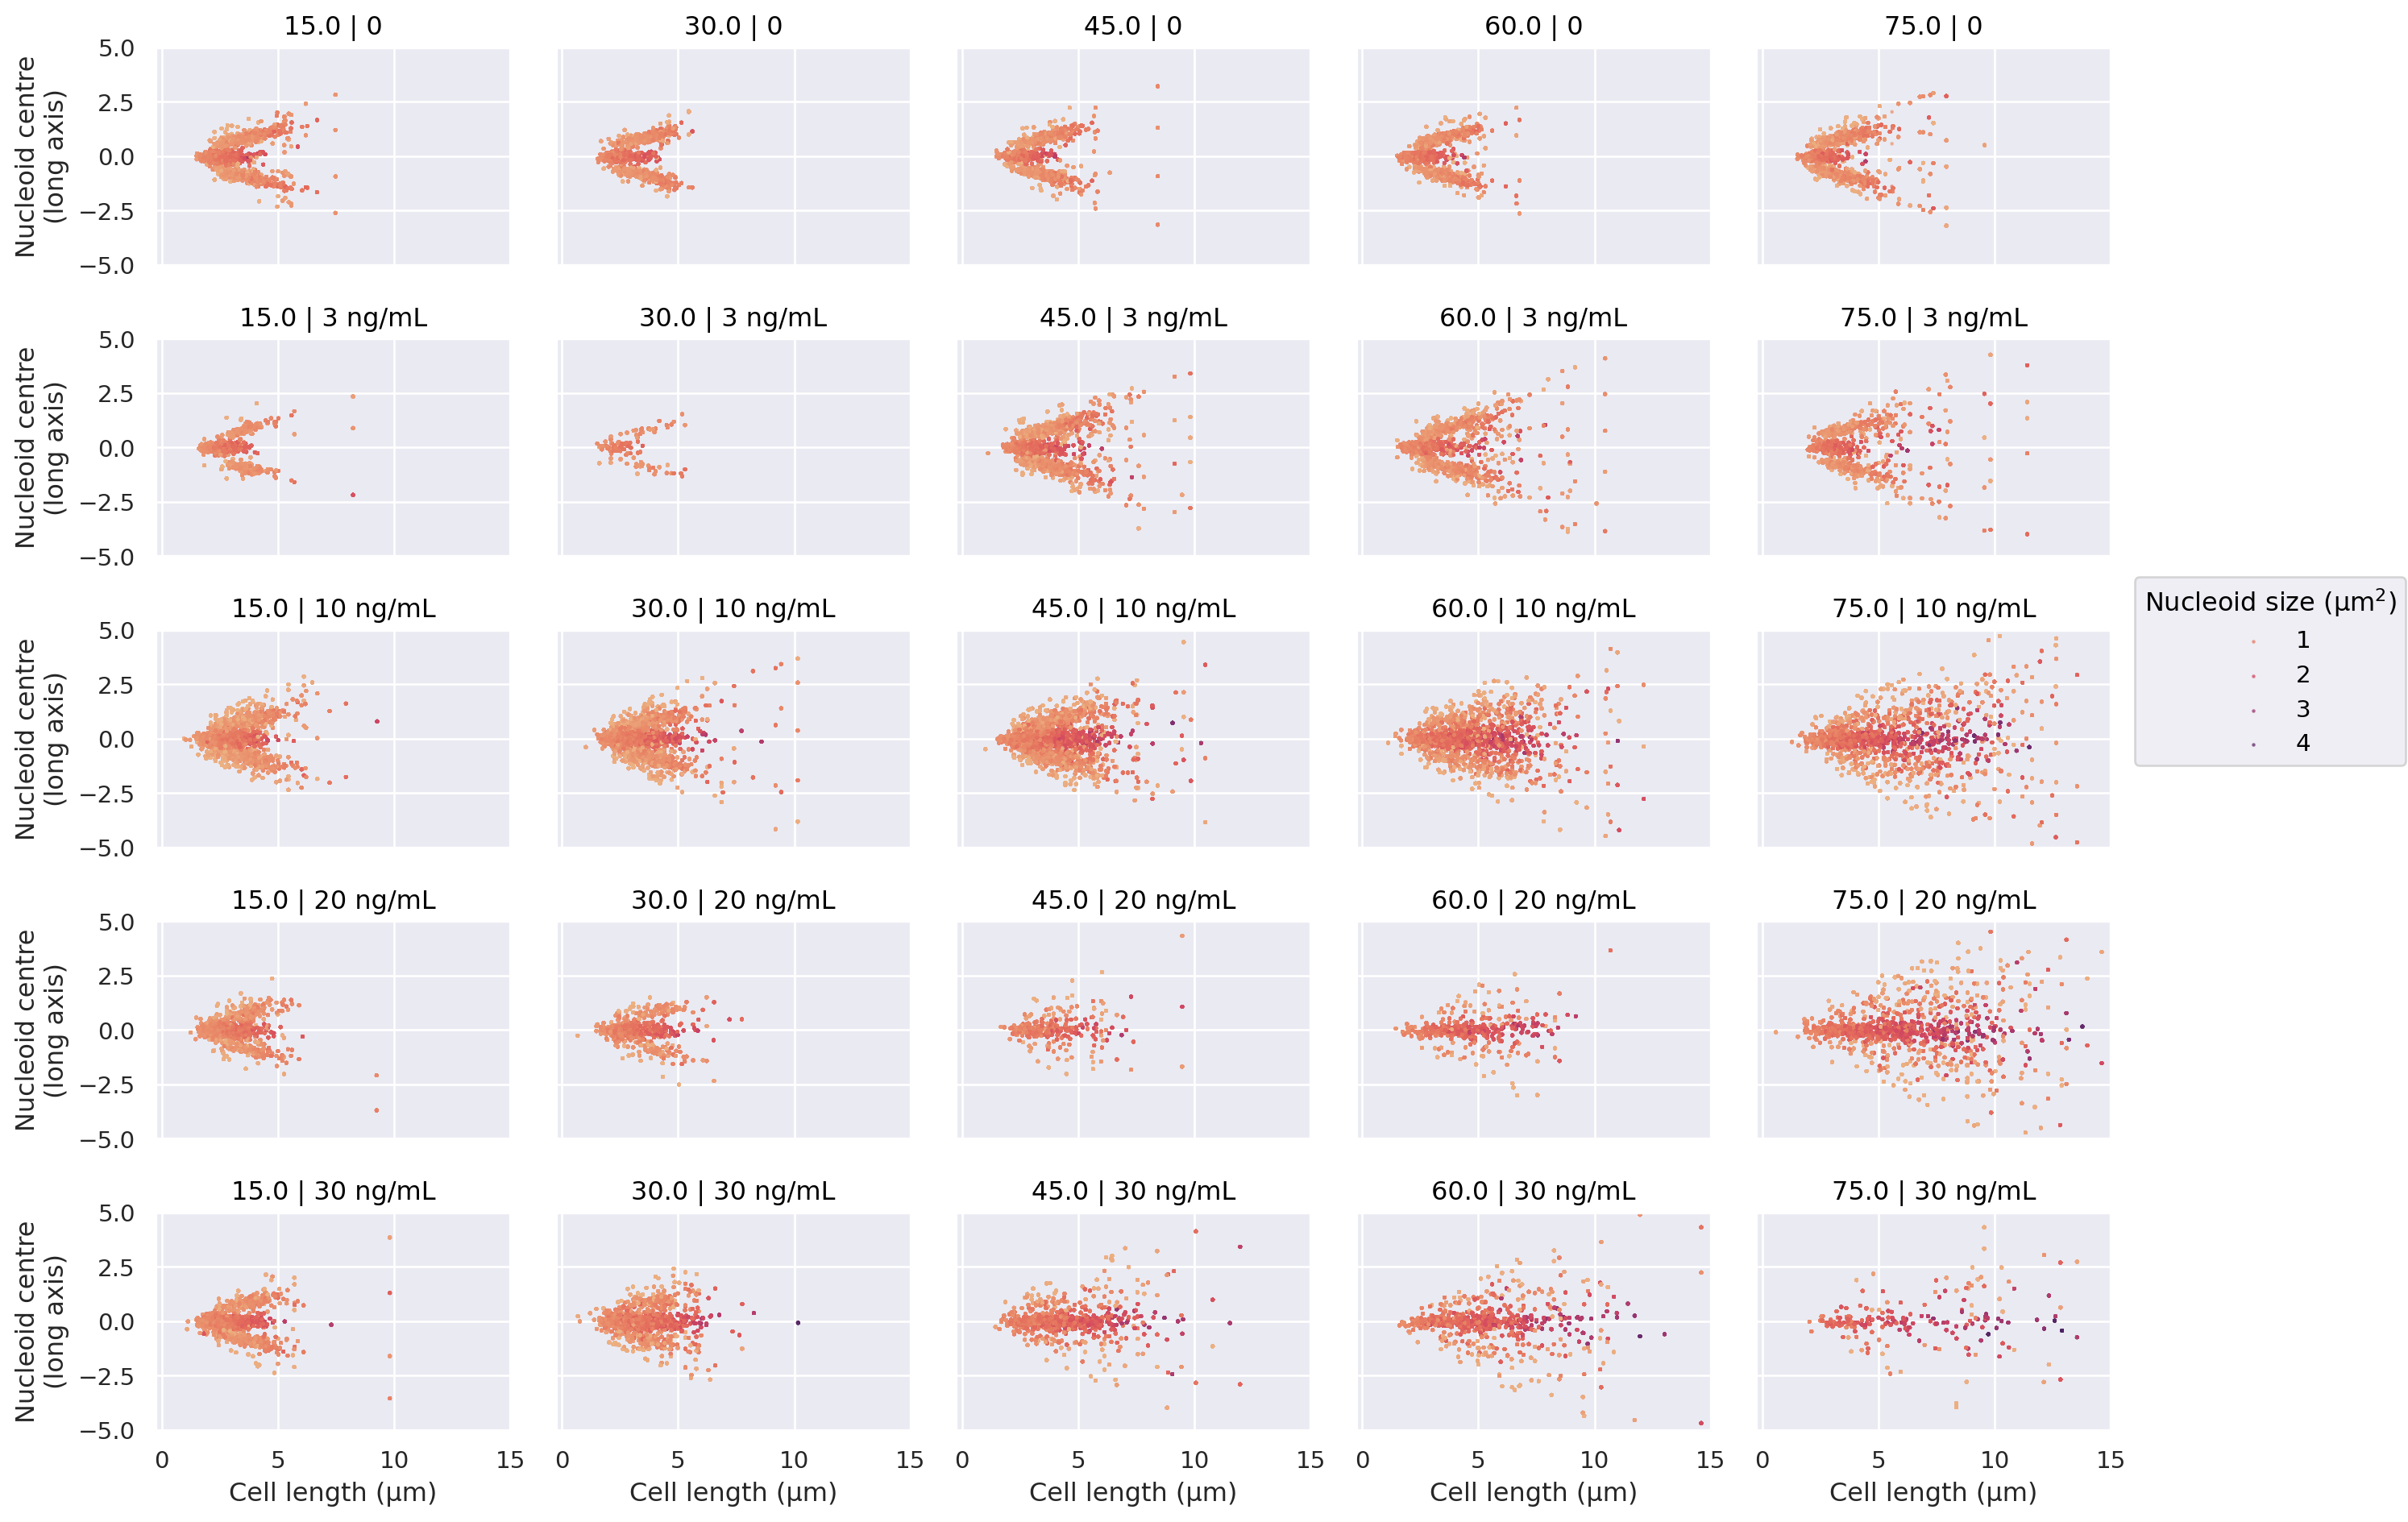

In [2]:
(
    so.Plot(data.Nucleoid, x='SpineLength', y='centerLongCoord', color='Nucleoid_size')
    .layout(size=(14,10))
    .facet(row='Group', col='Time_min_bin')
    .add(so.Dots(marker='.', alpha=.6, fillalpha=.6, pointsize=2))
    .limit(x=(None, 15), y=(-5, 5))
    .scale(color='flare')
    .label(x='Cell length (µm)', y='Nucleoid centre\n(long axis)', color='Nucleoid size (µm$^2$)')
)

In [3]:
df = (data
      .Bacteria_large
      .assign(no_nucleoid=lambda df: df.NucleoidCount.eq(0).astype('int')*100,
              )
      .groupby(['Group'])
      .agg({'no_nucleoid':'mean'})
      .assign(no_nucleoid=lambda df: df.no_nucleoid.astype('int').astype('str') + '%')
      .rename(columns={'no_nucleoid':'Cells with no nucleoid'})
      )

display(df)

,Cells with no nucleoid
Group,
0,1%
10 ng/mL,5%
20 ng/mL,0%
3 ng/mL,0%
30 ng/mL,2%


## Sytox intensity

In [4]:
data.describe(object_name='Bacteria_large')

Bacteria_large


,Group,nObjects,RecBIntensity,Area,SNR,RecBSpotCount,SpineWidth,SpineLength,NextDivisionFrame,PreviousDivisionFrame,NucleoidCount,Time_min,Time_min_bin
Dataset,,,,,,,,,,,,,
240424_1,0,49600,3599.316919,3.014601,429.832473,0.030060,0.842242,3.114085,NaN,NaN,1.426411,37.283867,29.667339
240612_1,0,86050,4477.801611,2.958137,416.877814,0.060686,0.825554,3.109122,NaN,NaN,1.535200,50.671043,43.893085
240620_1,0,48800,4305.768146,2.809861,285.585488,0.055902,0.837626,2.922878,NaN,NaN,1.450861,57.310529,50.548156
240717_3,3 ng/mL,114500,4032.524520,3.185769,262.549494,0.060926,0.804337,3.401630,NaN,NaN,1.498690,56.465699,47.895197
240620_3,10 ng/mL,135300,4512.396023,3.571471,304.856552,0.067435,0.839039,3.725666,NaN,NaN,1.256837,51.223607,43.702882
240717_1,10 ng/mL,60950,4237.621624,3.015663,466.557113,0.066694,0.764343,3.348316,NaN,NaN,1.002461,42.458187,35.746514
240717_2,10 ng/mL,134750,4013.983373,3.438402,363.011784,0.060616,0.767979,3.808128,NaN,NaN,1.345455,47.240754,40.252319
240717_4,20 ng/mL,133800,3906.764460,3.741756,335.856214,0.077960,0.808811,3.978586,NaN,NaN,1.224215,49.073223,41.328475
240424_2,30 ng/mL,80000,3608.020641,3.251460,583.069648,0.040675,0.829891,3.411693,NaN,NaN,1.183750,38.159507,31.734375


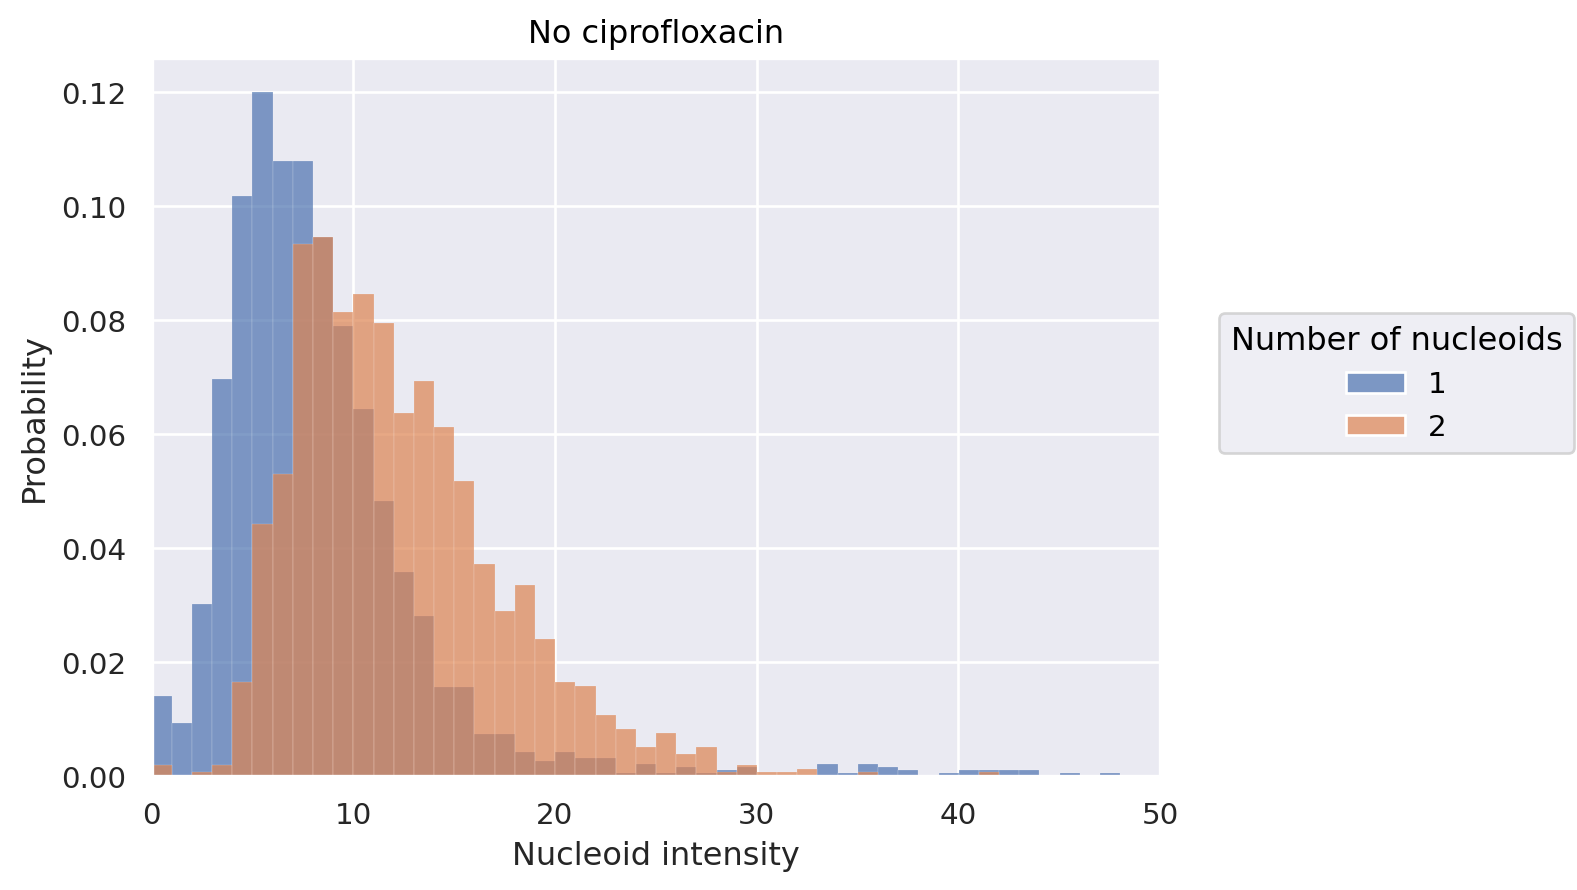

In [5]:
df = (data
      .add_from_child(object_name='Bacteria_large', child='Nucleoid', col='SNR', rename='Nucleoid_SNR', agg='sum')
      .Bacteria_large
      .query('Group == "0" and NucleoidCount <= 2 and NucleoidCount > 0')
      )

(
    so.Plot(df, x='Nucleoid_SNR', color='NucleoidCount')
    .add(so.Bars(), so.Hist(stat='probability', binwidth=1, common_norm=False))
    .limit(x=(0, 50))
    .scale(color=so.Nominal())
    .label(x='Nucleoid intensity', y='Probability', color='Number of nucleoids', title='No ciprofloxacin')
)

## Nucleoid/RecB colocalisation

In [6]:
df = (data
      .RecB_spots
      .assign(spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.notna().astype('int')*100,
              long_spot=lambda df: df.TrackLength.ge(5)
              )
      .query('long_spot == True')
      .groupby(['Group'])
      .agg({'spot_in_nucleoid':'mean'})
      .assign(spot_in_nucleoid=lambda df: df.spot_in_nucleoid.astype('int').astype('str') + '%')
      .rename(columns={'spot_in_nucleoid':'DNA-bound RecB in a nucleoid'})
      )

display(df)

,DNA-bound RecB in a nucleoid
Group,
0,70%
10 ng/mL,71%
20 ng/mL,85%
3 ng/mL,78%
30 ng/mL,82%


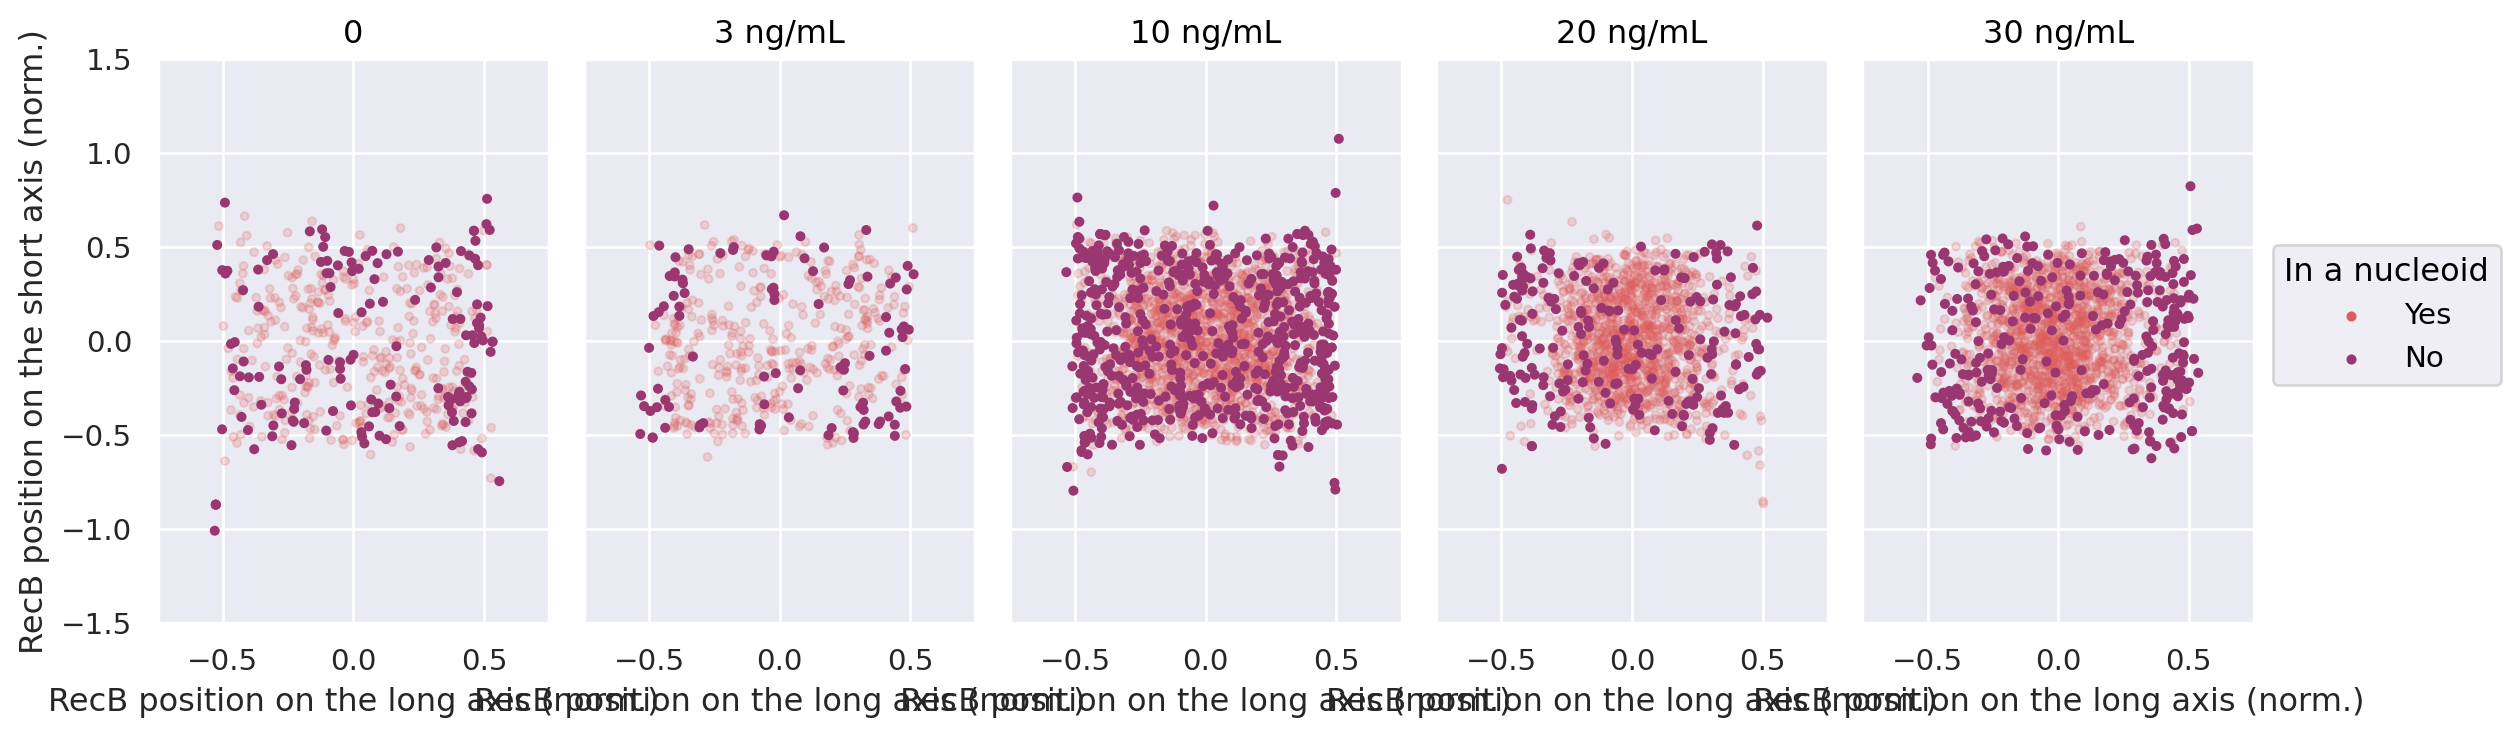

In [7]:
df = (data
      .apply_filters({'RecB_spots':'TrackLength >= 5'})
      .assign(object_name='RecB_spots', spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.notna().astype('int'))
      .add_from_child(object_name='Bacteria_large', col='centerLongCoord', child='Nucleoid', agg='first', rename='nucleoid_pos')
      .add_from_child(object_name='Bacteria_large', col=['normLongCoord', 'normShortCoord', 'spot_in_nucleoid'], child='RecB_spots', agg='first', rename=['RecB_long', 'RecB_short', 'in_nucleoid'])
      .Bacteria_large
      .assign(in_nucleoid=lambda df: df.in_nucleoid.replace({0:'No', 1:'Yes'}))
      )

(
    so.Plot(df, x='RecB_long', y='RecB_short', color='in_nucleoid')
    .layout(size=(15,4))
    .facet(col='Group')
    .add(so.Dots(marker='.', alpha=.2, fillalpha=.2, pointsize=6), data=df.query('in_nucleoid == "Yes"'))
    .add(so.Dots(marker='.', alpha=1, fillalpha=1, pointsize=6), data=df.query('in_nucleoid == "No"'))
    .limit(x=(-.75, .75), y=(-1.5, 1.5))
    .scale(color='flare')
    .label(x='RecB position on the long axis (norm.)', y='RecB position on the short axis (norm.)', color='In a nucleoid')
)

WT 30 ng/mL, normalised by cell length, only for cells with 1-2 nucleoids

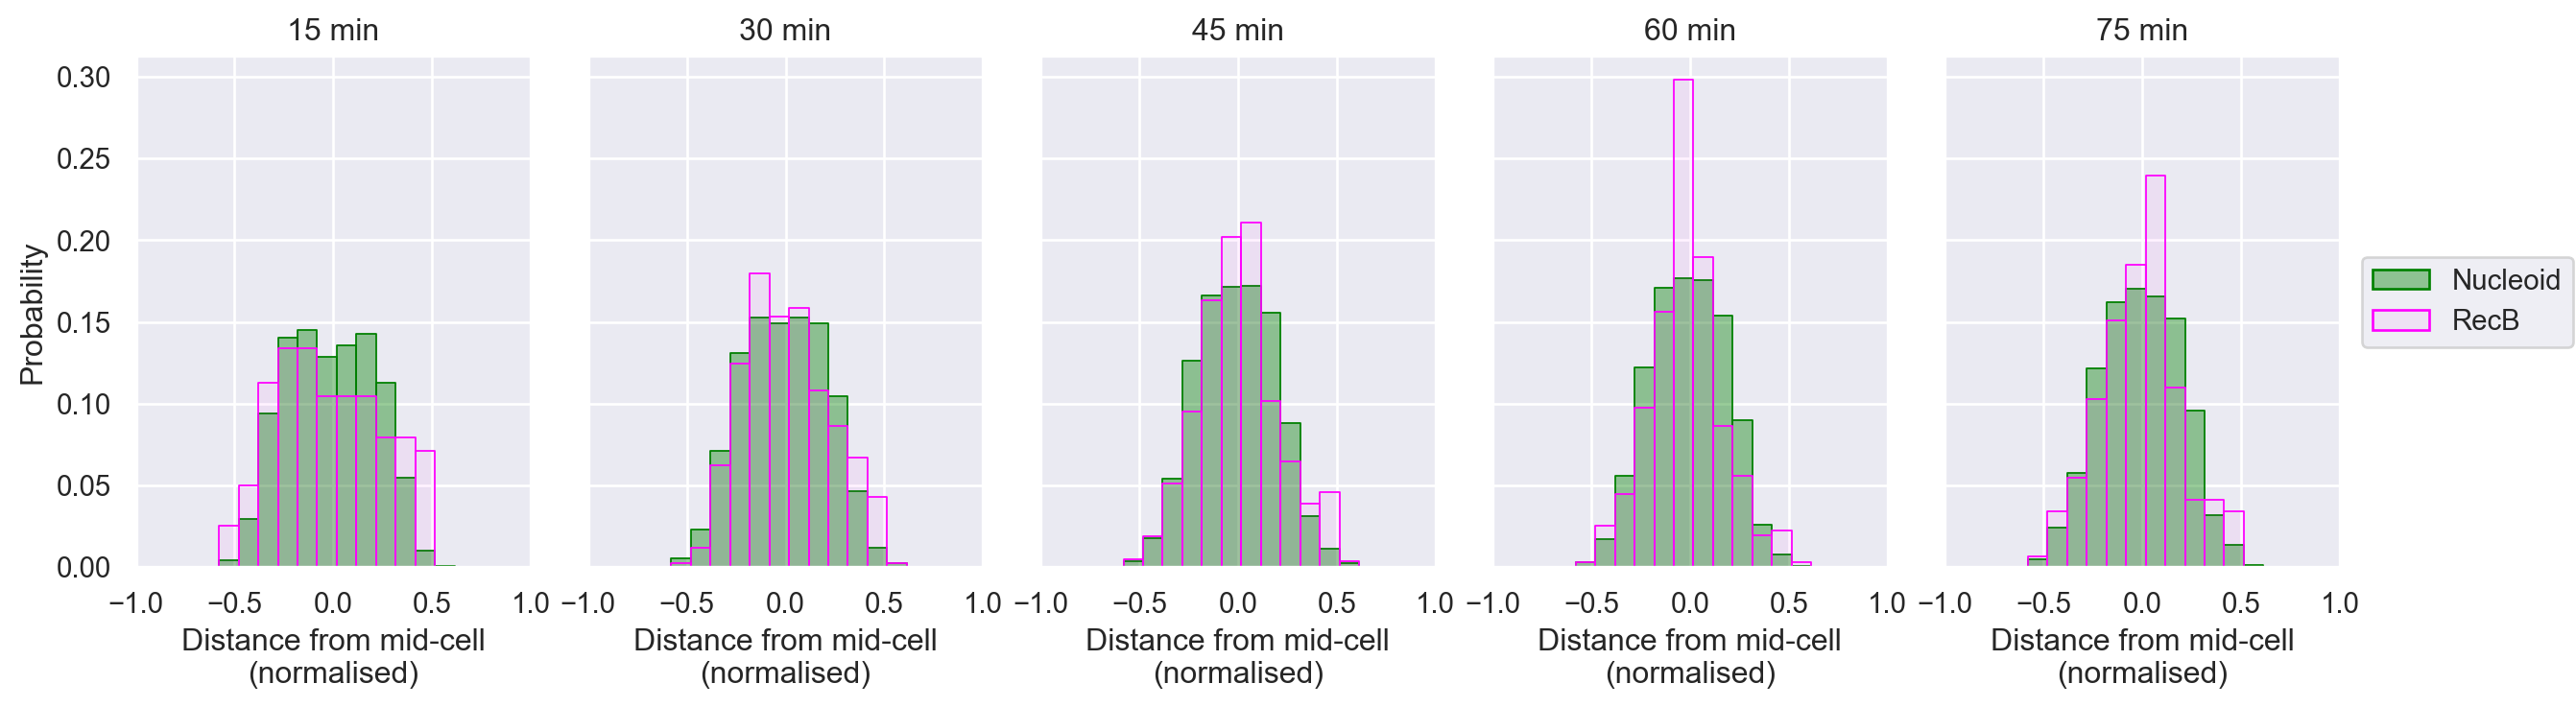

In [32]:
dx = 0.05

df = (pd.concat([data
                .add_from_parent(object_name='Nucleoid', col='NucleoidCount')
                .apply_filters({'Nucleoid':'Group == "30 ng/mL"', 'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .Nucleoid
                .dropna()
                .assign(NucleoidLength=lambda df: df.NucleoidLength / df.SpineLength,
                        LowerBound=lambda df: df.normLongCoord - df.NucleoidLength/2,
                        nPoints=lambda df: round(df.NucleoidLength / dx).astype('int')
                        )
                .pipe(lambda df: df.loc[df.index.repeat(df.nPoints)])
                .reset_index(names='id')
                .assign(SubID=lambda df: df.groupby('id')['id'].cumcount() +0.5,
                        Density=lambda df: df.LowerBound + df.SubID *dx,
                        Object='Nucleoid'
                        )
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'NucleoidCount', 'Object']],
                data
                .add_from_parent(object_name='RecB_spots', col='NucleoidCount')
                .apply_filters({'RecB_spots': 'TrackLength >= 5 and Group == "30 ng/mL"', 'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .RecB_spots
                .assign(Object='RecB')
                .rename(columns={'normLongCoord':'Density'})
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'NucleoidCount', 'Object']]
                ])
      .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('int').astype('str') + ' min',
              NucleoidCount=lambda df: df.NucleoidCount.astype('str') + ' nucleoids')  
      )

(
    so.Plot(df, x='Density', edgecolor='Object', color='Object', alpha='Object')
    .facet(col='Time_min_bin')
    .layout(size=(13,4))
#     .add(so.Area(), so.KDE(bw_adjust=1.5, common_norm=False, cut=20))
    .add(so.Bars(), so.Hist(binwidth=.1, common_norm=False, stat='probability'))
    .scale(edgecolor=['green', 'magenta'], color=['green', 'magenta'], alpha=[.4, .05])
    .label(x='Distance from mid-cell\n(normalised)', y='Probability', color='', alpha='', edgecolor='')
    .limit(x=(-1, 1), y=(0, None))
#     .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/Nucleoid_RecB_position.svg', format='svg', bbox_inches='tight')
)

WT 30 ng/mL, normalised by cell length, split by number of nucleoids (1 or 2)

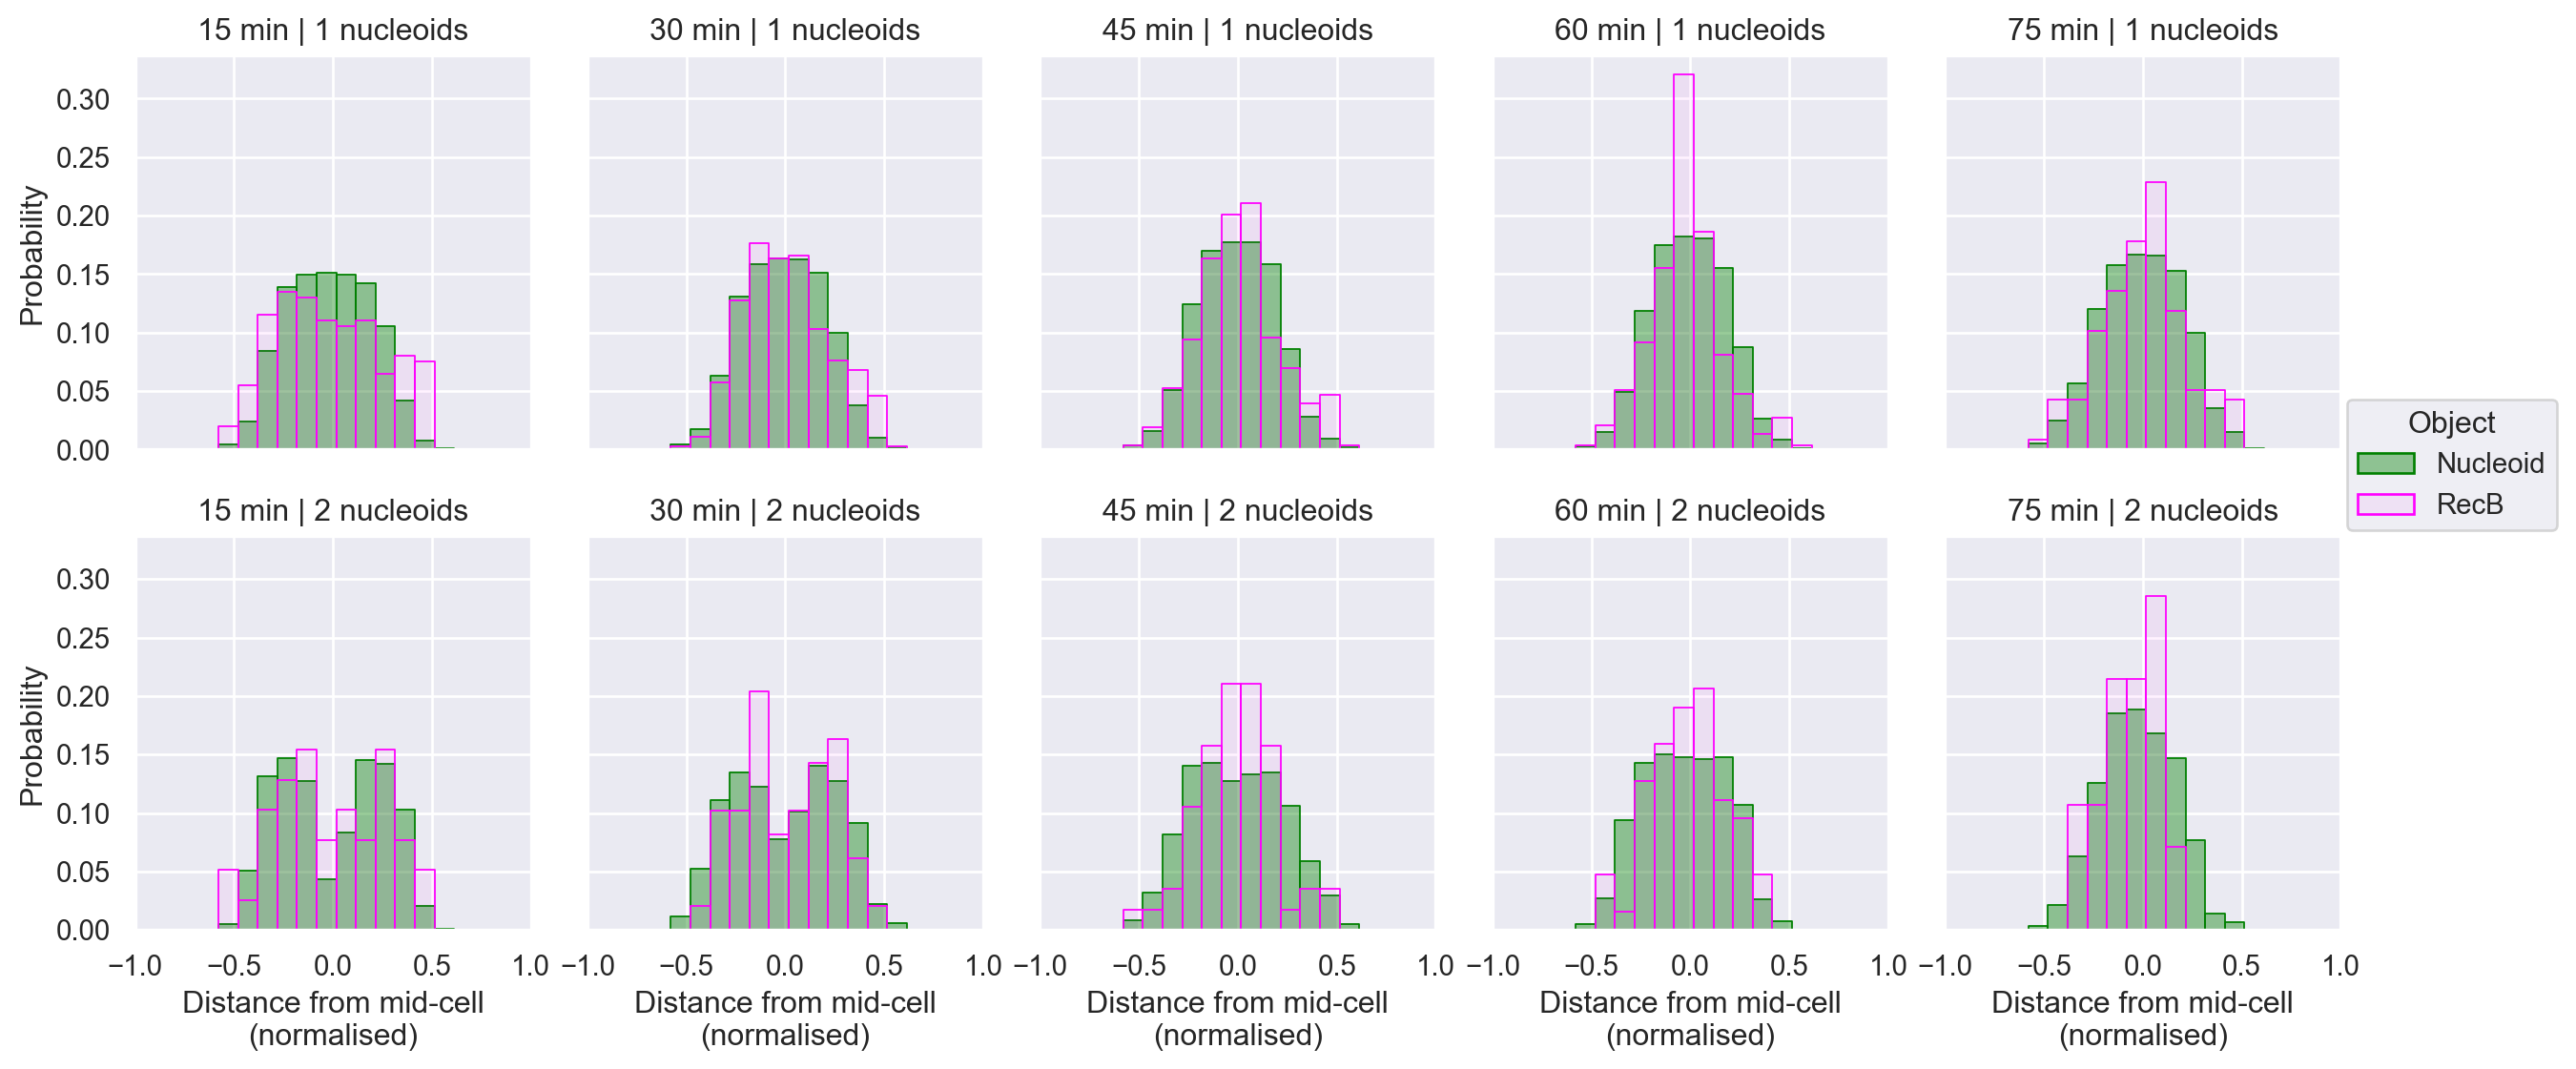

In [33]:
dx = 0.05

df = (pd.concat([data
                .add_from_parent(object_name='Nucleoid', col='NucleoidCount')
                .apply_filters({'Nucleoid':'Group == "30 ng/mL"', 'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .Nucleoid
                .dropna()
                .assign(NucleoidLength=lambda df: df.NucleoidLength / df.SpineLength,
                        LowerBound=lambda df: df.normLongCoord - df.NucleoidLength/2,
                        nPoints=lambda df: round(df.NucleoidLength / dx).astype('int')
                        )
                .pipe(lambda df: df.loc[df.index.repeat(df.nPoints)])
                .reset_index(names='id')
                .assign(SubID=lambda df: df.groupby('id')['id'].cumcount() +0.5,
                        Density=lambda df: df.LowerBound + df.SubID *dx,
                        Object='Nucleoid'
                        )
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'NucleoidCount', 'Object']],
                data
                .add_from_parent(object_name='RecB_spots', col='NucleoidCount')
                .apply_filters({'RecB_spots': 'TrackLength >= 5 and Group == "30 ng/mL"', 'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .RecB_spots
                .assign(Object='RecB')
                .rename(columns={'normLongCoord':'Density'})
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'NucleoidCount', 'Object']]
                ])
      .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('int').astype('str') + ' min',
              NucleoidCount=lambda df: df.NucleoidCount.astype('str') + ' nucleoids')  
      )

(
    so.Plot(df, x='Density', edgecolor='Object', color='Object', alpha='Object')
    .facet(col='Time_min_bin', row='NucleoidCount')
    .layout(size=(13,6))
#     .add(so.Area(), so.KDE(bw_adjust=1.5, common_norm=False, cut=20))
    .add(so.Bars(), so.Hist(binwidth=.1, common_norm=False, stat='probability'))
    .scale(edgecolor=['green', 'magenta'], color=['green', 'magenta'], alpha=[.4, .05])
    .label(x='Distance from mid-cell\n(normalised)', y='Probability')
    .limit(x=(-1, 1), y=(0, None))
)

Split by groups, normalised by cell length, cells with 1-2 nucleoids

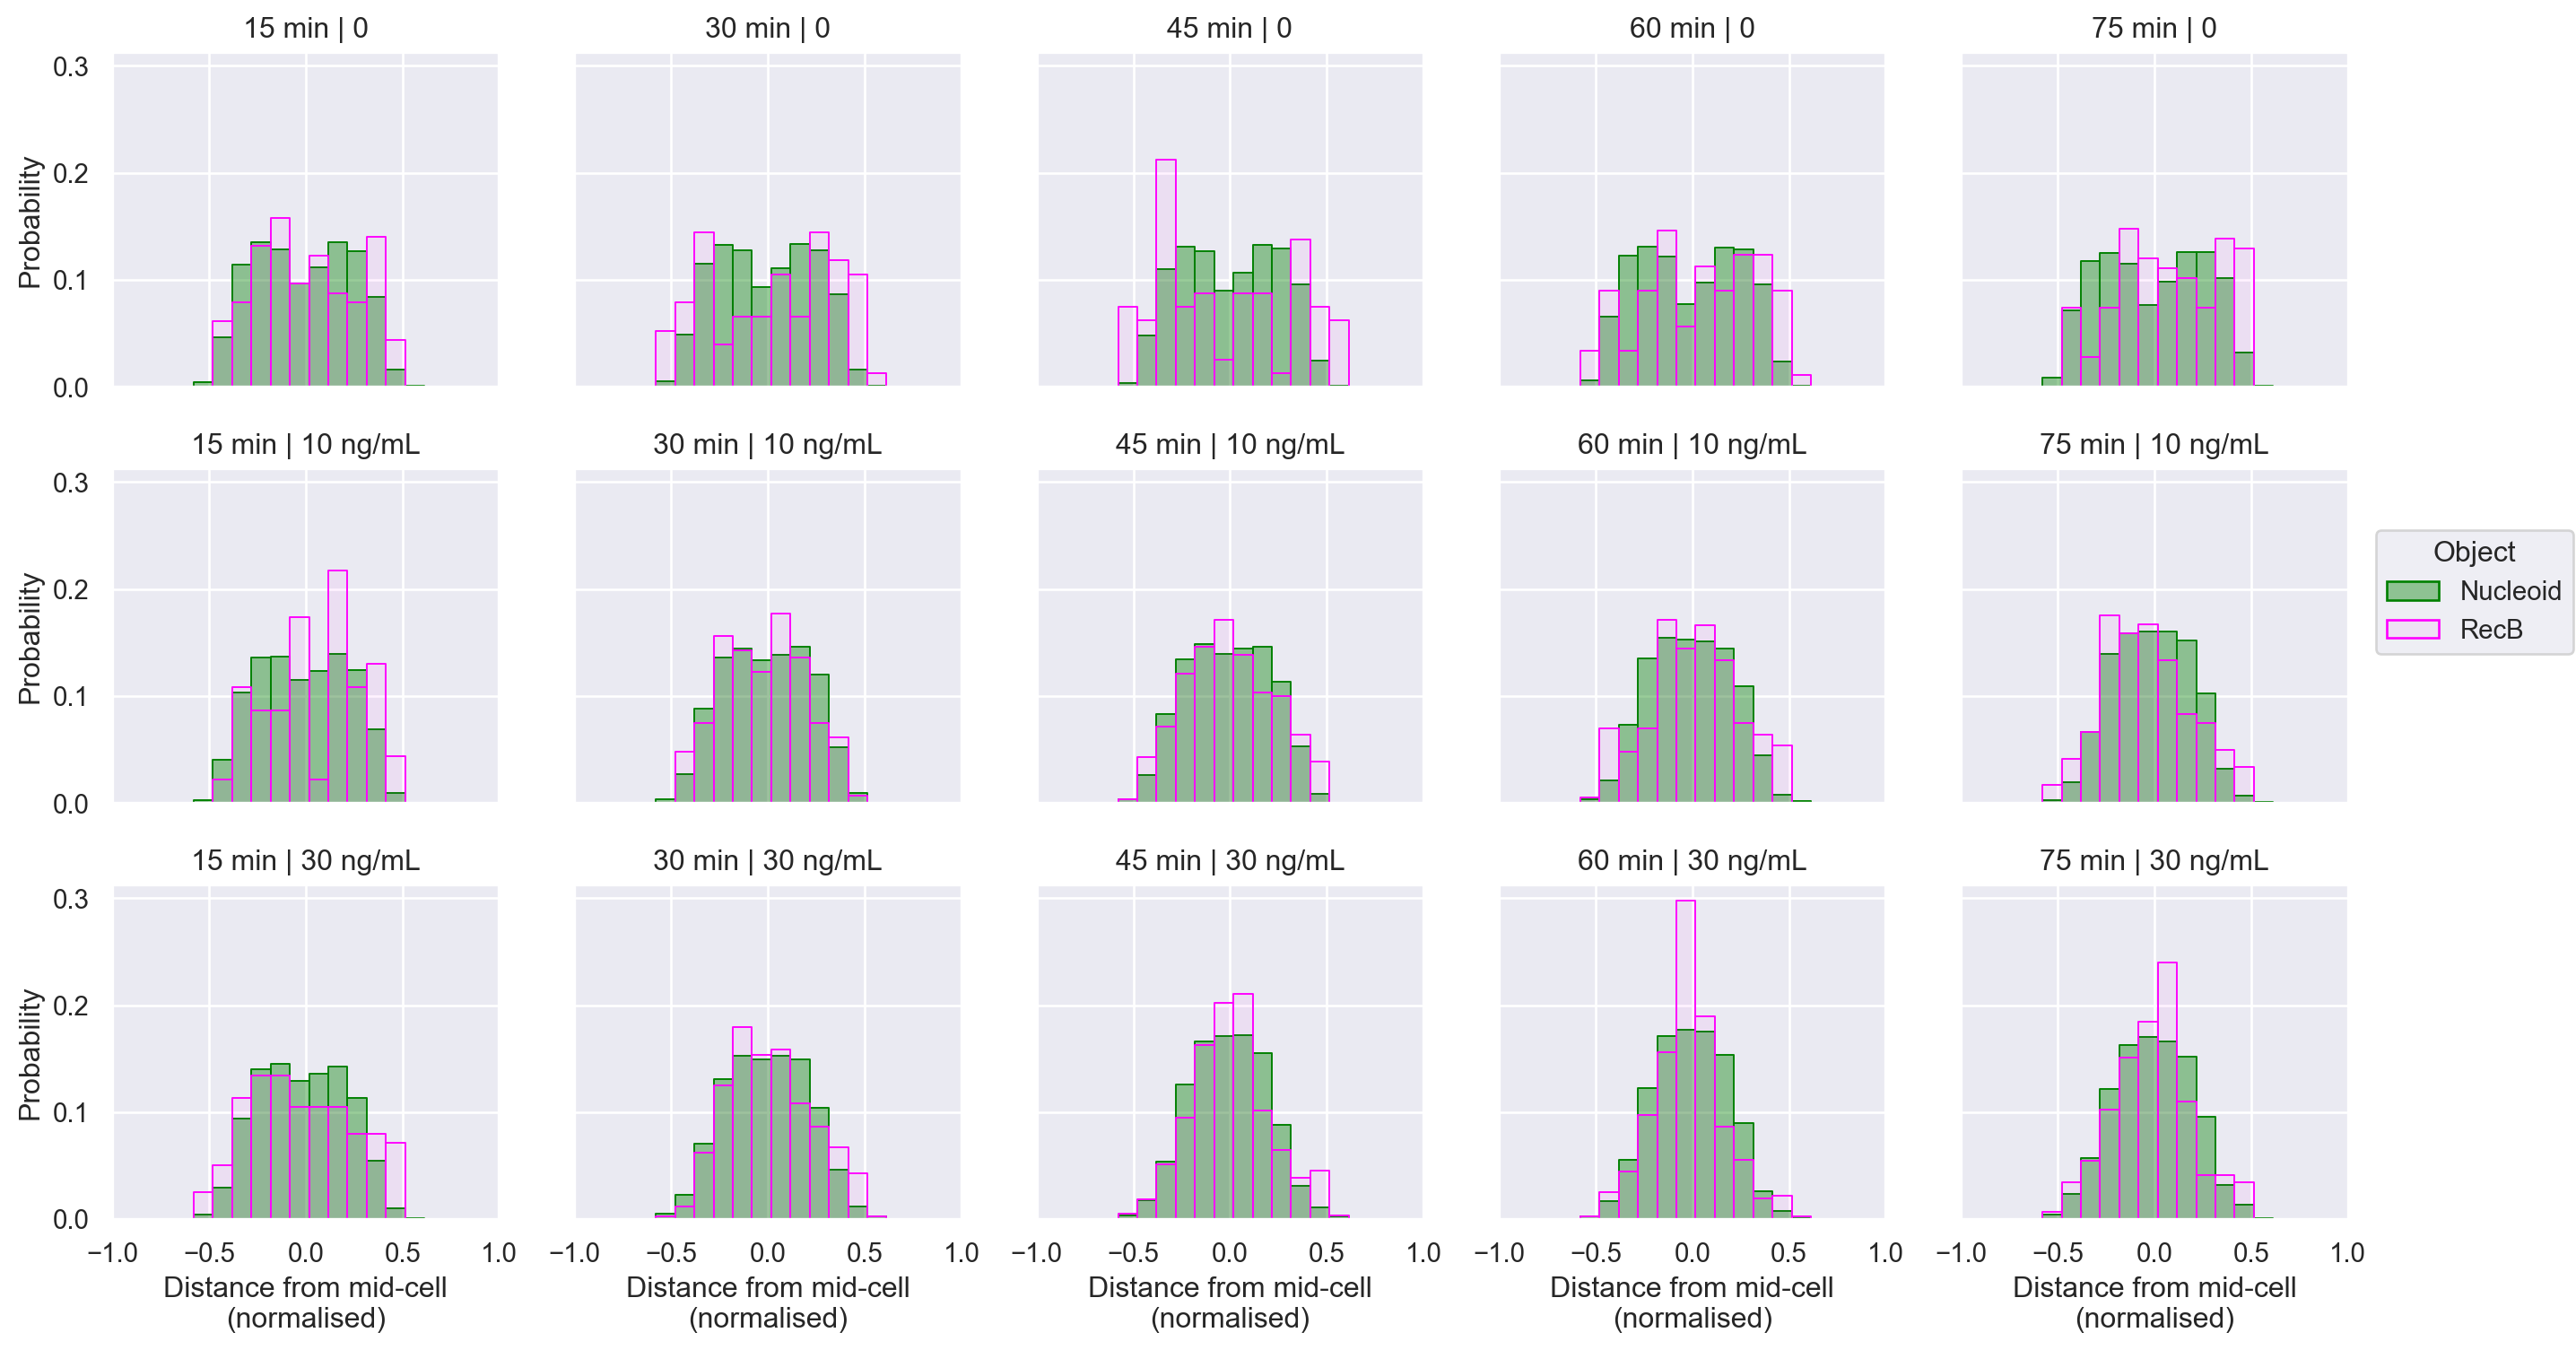

In [34]:
dx = 0.05

df = (pd.concat([data
                .add_from_parent(object_name='Nucleoid', col='NucleoidCount')
                .apply_filters({'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .Nucleoid
                .dropna()
                .assign(NucleoidLength=lambda df: df.NucleoidLength / df.SpineLength,
                        LowerBound=lambda df: df.normLongCoord - df.NucleoidLength/2,
                        nPoints=lambda df: round(df.NucleoidLength / dx).astype('int')
                        )
                .pipe(lambda df: df.loc[df.index.repeat(df.nPoints)])
                .reset_index(names='id')
                .assign(SubID=lambda df: df.groupby('id')['id'].cumcount() +0.5,
                        Density=lambda df: df.LowerBound + df.SubID *dx,
                        Object='Nucleoid'
                        )
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'NucleoidCount', 'Object']],
                data
                .add_from_parent(object_name='RecB_spots', col='NucleoidCount')
                .apply_filters({'RecB_spots': 'TrackLength >= 5', 'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .RecB_spots
                .assign(Object='RecB')
                .rename(columns={'normLongCoord':'Density'})
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'Object']]
                ])
      .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('int').astype('str') + ' min')
      )

(
    so.Plot(df, x='Density', edgecolor='Object', color='Object', alpha='Object')
    .facet(col='Time_min_bin', row='Group')
    .layout(size=(14,8))
    .add(so.Bars(), so.Hist(binwidth=.1, common_norm=False, stat='probability'))
    .scale(edgecolor=['green', 'magenta'], color=['green', 'magenta'], alpha=[.4, .05])
    .label(x='Distance from mid-cell\n(normalised)', y='Probability')
    .limit(x=(-1, 1), y=(0, None))
)

Without normalisation to cell length:

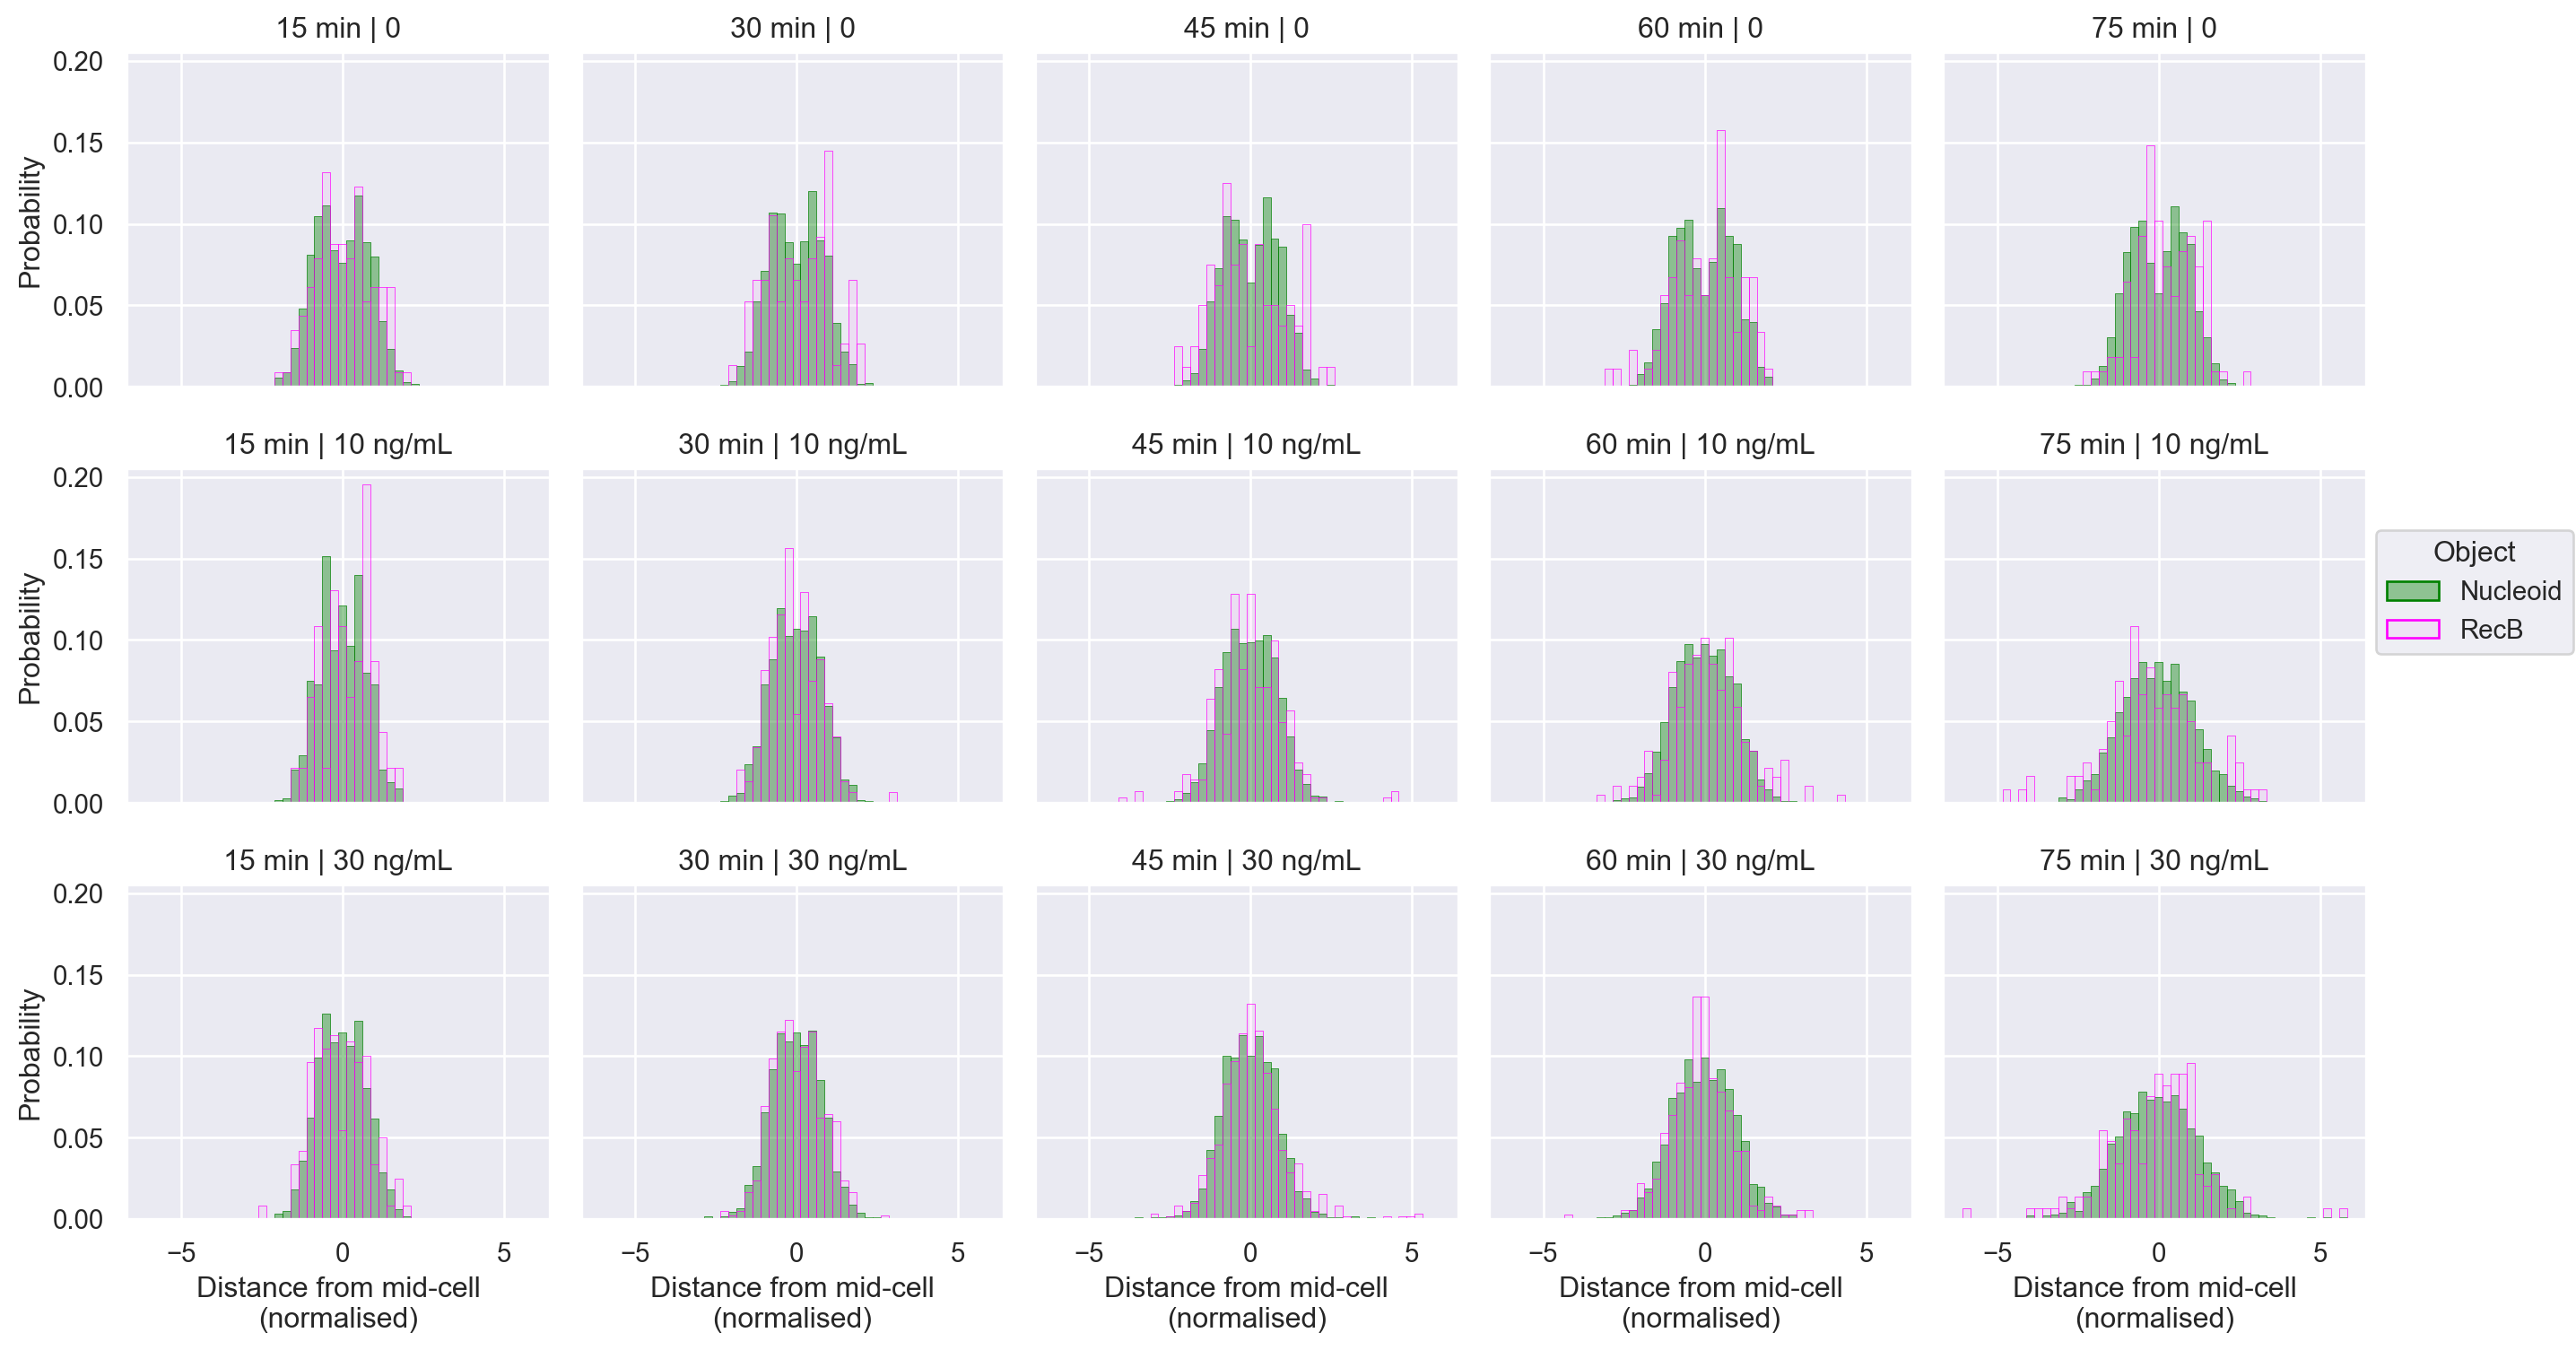

In [35]:
dx = 0.5

df = (pd.concat([data
                .add_from_parent(object_name='Nucleoid', col='NucleoidCount')
                .apply_filters({'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .Nucleoid
                .dropna()
                .assign(LowerBound=lambda df: df.centerLongCoord - df.NucleoidLength/2,
                        nPoints=lambda df: round(df.NucleoidLength / dx).astype('int')
                        )
                .pipe(lambda df: df.loc[df.index.repeat(df.nPoints)])
                .reset_index(names='id')
                .assign(SubID=lambda df: df.groupby('id')['id'].cumcount() +0.5,
                        Density=lambda df: df.LowerBound + df.SubID *dx,
                        Object='Nucleoid'
                        )
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'Object']],
                data
                .add_from_parent(object_name='RecB_spots', col='NucleoidCount')
                .apply_filters({'RecB_spots': 'TrackLength >= 5', 'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .RecB_spots
                .assign(Object='RecB')
                .rename(columns={'centerLongCoord':'Density'})
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'Object']]
                ])
        .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('int').astype('str') + ' min')
        )

(
    so.Plot(df, x='Density', edgecolor='Object', color='Object', alpha='Object')
    .facet(col='Time_min_bin', row='Group')
    .layout(size=(14,8))
    .add(so.Bars(), so.Hist(binwidth=0.25, common_norm=False, stat='probability'))
    .scale(edgecolor=['green', 'magenta'], color=['green', 'magenta'], alpha=[.4, .05])
    .label(x='Distance from mid-cell\n(normalised)', y='Probability')
#     .limit(x=(-4, 4), y=(0, None))
)

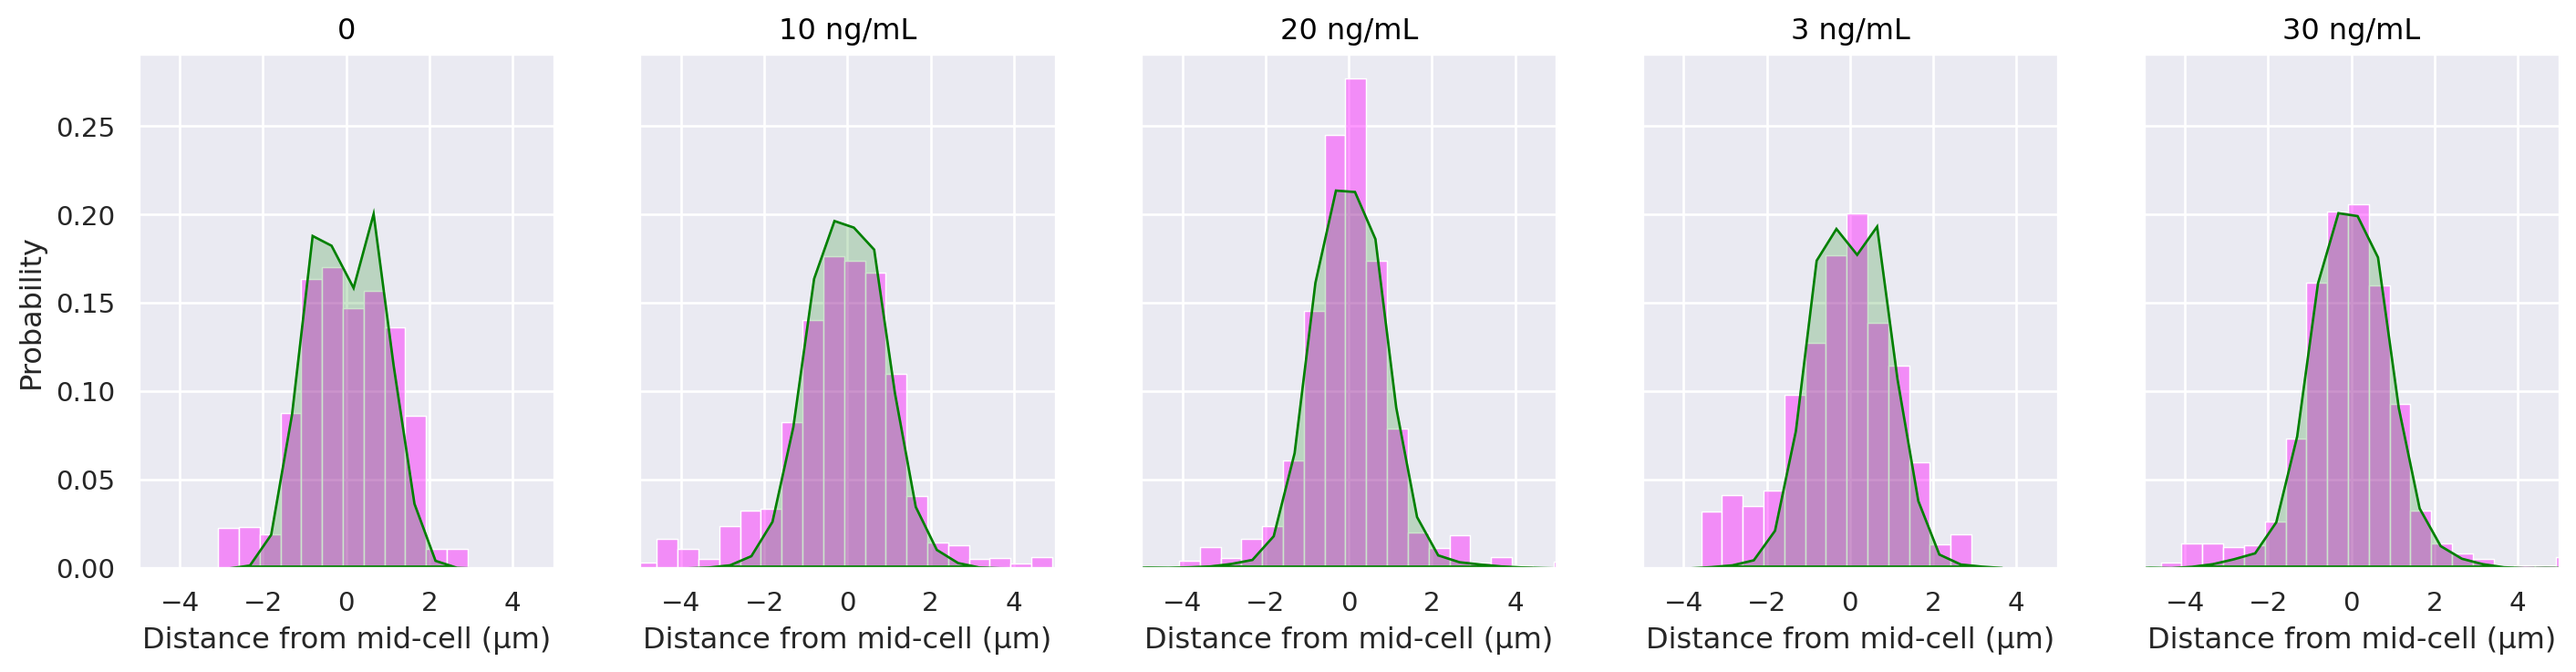

In [8]:
dx = 0.5

df = (pd.concat([data
                .add_from_parent(object_name='Nucleoid', col='NucleoidCount')
                .apply_filters({'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .Nucleoid
                .dropna()
                .assign(LowerBound=lambda df: df.centerLongCoord - df.NucleoidLength/2,
                        nPoints=lambda df: round(df.NucleoidLength / dx).astype('int')
                        )
                .pipe(lambda df: df.loc[df.index.repeat(df.nPoints)])
                .reset_index(names='id')
                .assign(SubID=lambda df: df.groupby('id')['id'].cumcount() +0.5,
                        Density=lambda df: df.LowerBound + df.SubID *dx,
                        Object='Nucleoid'
                        )
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'Object']],
                data
                .add_from_parent(object_name='RecB_spots', col='NucleoidCount')
                .apply_filters({'RecB_spots': 'TrackLength >= 5', 'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .RecB_spots
                .assign(Object='RecB')
                .rename(columns={'centerLongCoord':'Density'})
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'Object']]
                ])
        .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('int').astype('str') + ' min')
        )

hist = (get_histogram(df, col='Density', groupby=['Group', 'Time_min_bin', 'Object'], density=True, binsize=.5)
        .pipe(lambda df: pd.pivot_table(df, values='proportion', index=['Group', 'Time_min_bin', 'Density'], columns='Object'))
        .reset_index()
        )

(
    so.Plot(hist, x='Density')
#     .facet(col='Time_min_bin', row='Group')
    .facet(col='Group')
    .layout(size=(15,4))
    .add(so.Bars(color='magenta', alpha=.4), so.Agg(),  y='RecB')
    .add(so.Area(color='green'), so.Agg(), y='Nucleoid')
    .label(x='Distance from mid-cell (µm)', y='Probability')
    .limit(x=(-5, 5), y=(0, None))
)

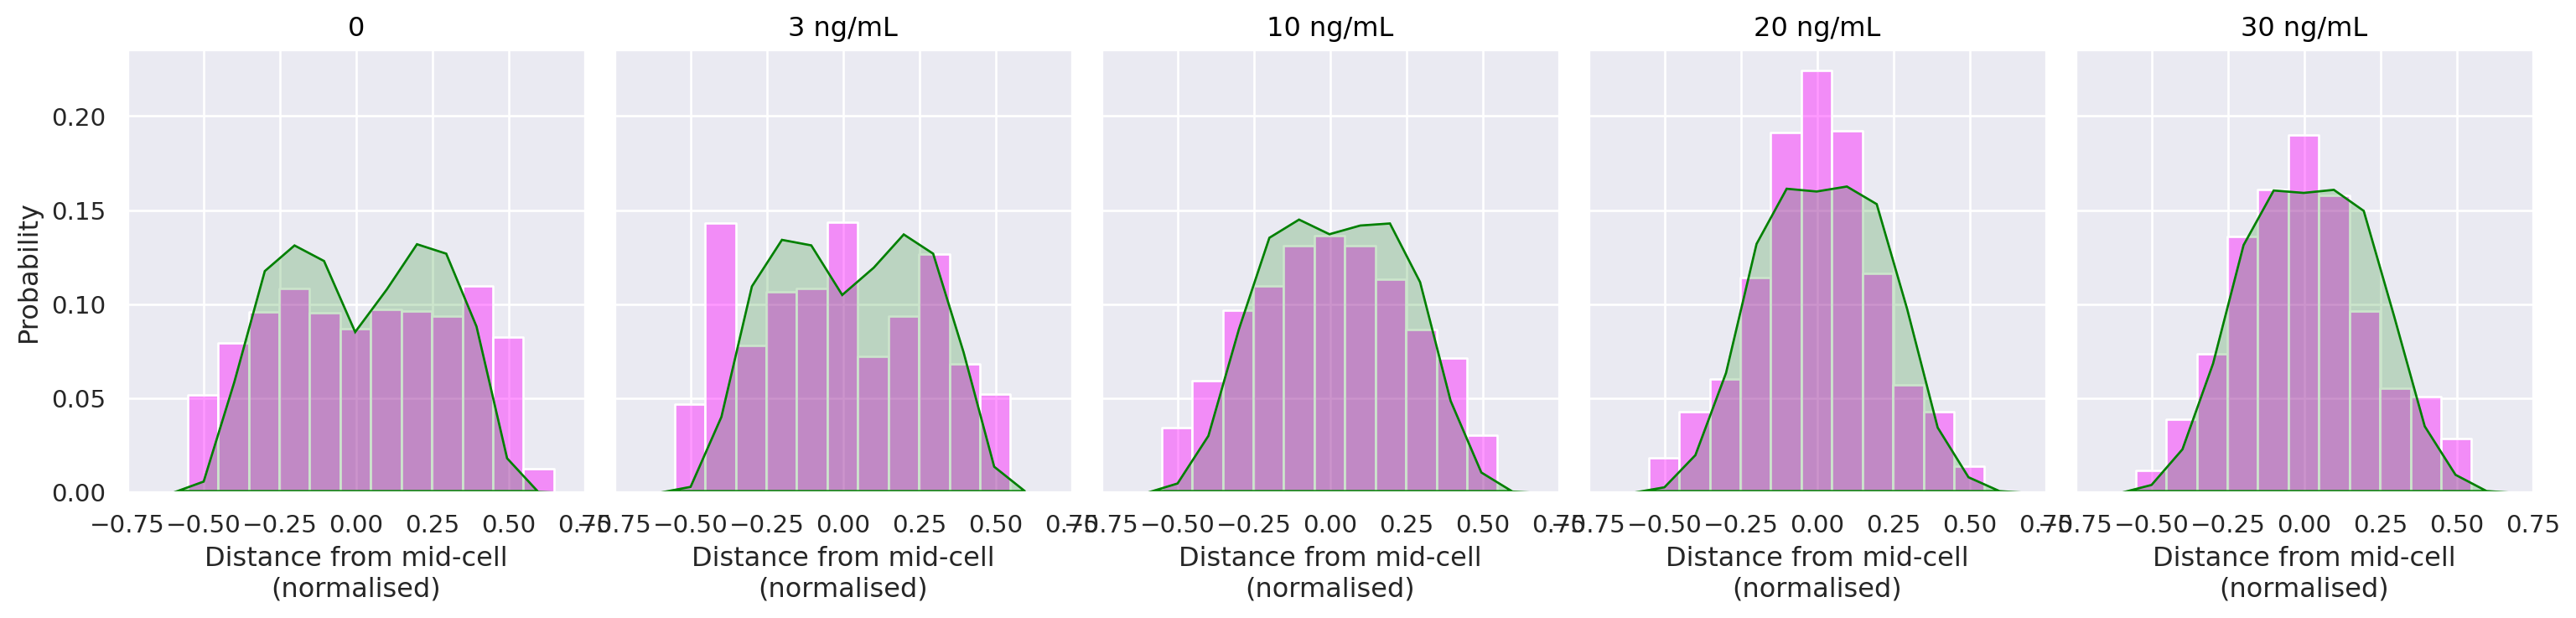

In [10]:
dx = 0.05

df = (pd.concat([data
                .add_from_parent(object_name='Nucleoid', col='NucleoidCount')
                .apply_filters({'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .Nucleoid
                .dropna()
                .assign(NucleoidLength=lambda df: df.NucleoidLength / df.SpineLength,
                        LowerBound=lambda df: df.normLongCoord - df.NucleoidLength/2,
                        nPoints=lambda df: round(df.NucleoidLength / dx).astype('int')
                        )
                .pipe(lambda df: df.loc[df.index.repeat(df.nPoints)])
                .reset_index(names='id')
                .assign(SubID=lambda df: df.groupby('id')['id'].cumcount() +1,
                        Density=lambda df: df.LowerBound + df.SubID *dx,
                        Object='Nucleoid'
                        )
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'Object']],
                data
                .add_from_parent(object_name='RecB_spots', col='NucleoidCount')
                .apply_filters({'RecB_spots': 'TrackLength >= 5', 'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .RecB_spots
                .assign(Object='RecB')
                .rename(columns={'normLongCoord':'Density'})
                [['Group', 'Dataset', 'Time_min_bin', 'Density', 'Object']]
                ])
        .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('int').astype('str') + ' min')
        )

hist = (get_histogram(df, col='Density', groupby=['Group', 'Time_min_bin', 'Object'], density=True, binsize=.1)
        .pipe(lambda df: pd.pivot_table(df, values='proportion', index=['Group', 'Time_min_bin', 'Density'], columns='Object'))
        .reset_index()
        )

(
    so.Plot(hist, x='Density')
    .facet(col='Group', order=['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL'])
    .layout(size=(16,4))
    .add(so.Bars(color='magenta', alpha=.4), so.Agg(),  y='RecB')
    .add(so.Area(color='green'), so.Agg(), y='Nucleoid')
    .label(x='Distance from mid-cell\n(normalised)', y='Probability')
    .limit(x=(-0.75, 0.75), y=(0, None))
)

In [5]:
from pybacmman.selections import store_selection

df = (data
      .apply_filters({'RecB_spots':'TrackLength >= 5'})
      .assign(object_name='RecB_spots', spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.notna().astype('int'))
      .add_from_child(object_name='Bacteria_large', col='centerLongCoord', child='Nucleoid', agg='first', rename='nucleoid_pos')
      .add_from_child(object_name='Bacteria_large', col=['spot_in_nucleoid'], child='RecB_spots', agg='first', rename=['in_nucleoid'])
      .Bacteria_large
      .assign(in_nucleoid=lambda df: df.in_nucleoid.replace({0:'No', 1:'Yes'}))
      .query('Dataset == "240424_2" and in_nucleoid == "No"')
      )

store_selection(df,
            #     dsPath='D:\\Daniel\\BACMMAN\\Timelapse',
                dsName="Timelapse\\240424_2",
                objectClassIdx=0,
                selectionName='Spot_non_nucleoid',
                port=25333, python_proxy_port=25334, address='127.0.0.1'
                )